In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tutorial

This tutorial guides you through the algorithm to use the burst-shape package.
It is based on the data of [Vinogradov et al. (2024)](https://doi.org/10.1101/2024.08.21.608974).
First, download the data from [here] and place it in the `data/data_inhibblock` folder.

## Test data
We first test whether the data is properly loaded and plot example traces.

(based on `scripts/1_preprocessing/001d_preload_inhibblock.py`)

/home/tim/anaconda3/envs/burst-shape/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-06 13:11:07,132	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Selected example, index 2, drug label = control


/tmp/ipykernel_176256/2549521837.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_176256/2549521837.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


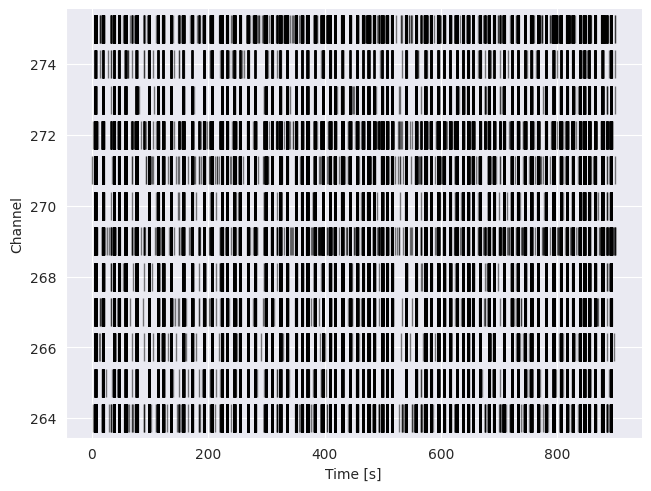

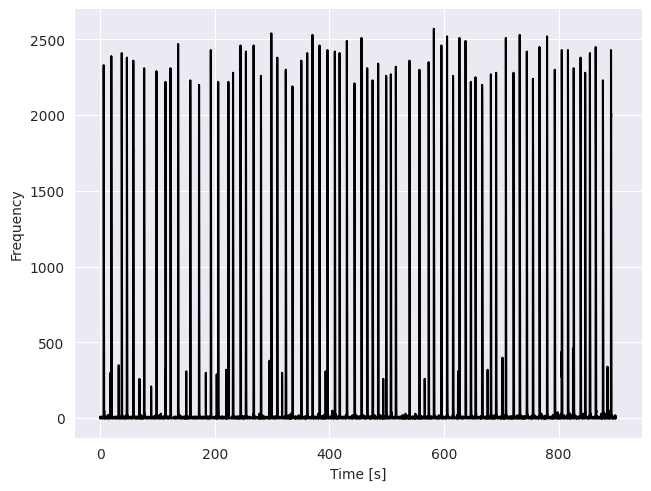

In [2]:
from src.folders import get_data_inhibblock_folder
# Test that data is properly loaded.
df = pd.read_pickle(os.path.join(get_data_inhibblock_folder(), "df_inhibblock.pkl"))

# %% example
index = 2
st, gid = df.iloc[index][["times", "gid"]]
print(f"Selected example, index {index}, drug label = {df.iloc[index].name[0]}")
# %% raster plot
fig, ax = plt.subplots(constrained_layout=True)
sns.despine()
ax.plot(st, gid, "|", ms=20, color="k", alpha=0.5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Channel")
fig.show()

# %% trace of firing rate
bin_size = 0.1  # s
times_all = np.arange(0, st.max() + bin_size, bin_size)
firing_rate = np.histogram(st, bins=times_all)[0] / (bin_size)  #  / 1000)
times_all = 0.5 * (times_all[1:] + times_all[:-1])

fig, ax = plt.subplots(constrained_layout=True)
sns.despine()
ax.plot(times_all, firing_rate, "-", color="k")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency")
fig.show()

## Detect and normalize bursts
Next, we
- detect the bursts based on inter-spike interval
- normalize the bursts to unit duration and unit integral
- save the results

(based on `scripts/1_preprocessing/002d_extract_bursts_inhibblock.py`)

Optionally, you can inspect the burst detection results interactively with `scripts/2_interactive_tools/002x_review_burst_detection`.

In [ ]:
from src.persistence import save_burst_extraction_params, save_df_cultures, save_df_bursts, save_burst_matrix
from src.preprocess import burst_extraction
from src.folders import get_data_inhibblock_folder

# parameters
params_burst_extraction = {
    "dataset": "inhibblock",
    "maxISIstart": 20,  # 5,
    "maxISIb": 20,  # 5,
    "minBdur": 50,  # 40,
    "minIBI": 100,
    "minSburst": 100,  # 50,
    "bin_size": None,
    "n_bins": 50,
    "extend_left": 0,
    "extend_right": 0,
    "burst_length_threshold": None,
    "pad_right": False,
    "normalization": "integral",
    "min_length": 30,
}


def _construct_inhibblock_df_cultures():
    return pd.read_pickle(
        os.path.join(get_data_inhibblock_folder(), "df_inhibblock.pkl")
    )


# extract bursts
df_cultures, df_bursts, burst_matrix = burst_extraction.extract_bursts(
    construct_df_cultures=_construct_inhibblock_df_cultures,
    **params_burst_extraction,
)

# save
save_burst_extraction_params(params_burst_extraction)

save_df_cultures(df_cultures, params_burst_extraction)
save_df_bursts(df_bursts, params_burst_extraction)
save_burst_matrix(burst_matrix, params_burst_extraction)

## Average burst shapes
The most basic analysis is to compute the average burst shapes per condition.
(based on `scripts/3_average_bursts/031b_plot_average_burst_shapes.py`)

Detected dataset: inhibblock


/tmp/ipykernel_176256/2827216754.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


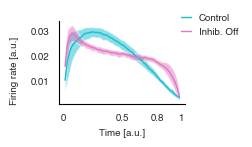

In [4]:
from matplotlib import ticker
from src.plot import prepare_plotting, get_group_colors, get_group_labels
from src.prediction.define_target import make_target_label
from src.persistence import load_df_bursts, load_df_cultures
from src.settings import get_dataset_from_burst_extraction_params
import scipy.stats


burst_extraction_params = "burst_dataset_inhibblock_maxISIstart_20_maxISIb_20_minBdur_50_minIBI_100_minSburst_100_n_bins_50_normalization_integral_min_length_30"
dataset = get_dataset_from_burst_extraction_params(burst_extraction_params)
print(f"Detected dataset: {dataset}")

# load data
df_bursts = load_df_bursts(burst_extraction_params)
df_cultures = load_df_cultures(burst_extraction_params)

# get average burst_shapes
index_names = df_cultures.index.names
df_cultures["avg_burst"] = df_bursts.groupby(index_names).agg(
    avg_burst=pd.NamedAgg(column="burst", aggfunc="mean")
)
df_cultures = df_cultures[df_cultures["n_bursts"] > 0]
df_cultures, target_label = make_target_label(
    dataset, df_cultures, special_target=False
)

# plot
cm = prepare_plotting()
background = [None, "recordings", "bursts"][1]
element = ["lines", "std", "3sem"][2]
x_values = np.arange(50) + 0.5  # 50 bins for the burst shape
fig, ax = plt.subplots(figsize=(8 * cm, 3.5 * cm), constrained_layout=True)
ax.set_position([0.25, 0.35, 0.4, 0.6])
sns.despine()
for i, group in enumerate(df_cultures["target_label"].unique()):
    color = (
        get_group_colors(dataset)[group]
        if get_group_colors(dataset) is not None
        else f"C{i}"
    )
    df_group = df_cultures[df_cultures["target_label"] == group]["avg_burst"]
    match background:
        case "recordings":
            match element:
                case "lines":
                    ax.plot(
                        # x_values,
                        np.vstack(df_group).T,
                        color=color,
                        alpha=0.5,
                        linewidth=0.5,
                        zorder=1,
                    )
                case "std":
                    ax.fill_between(
                        x_values,
                        df_group.mean() - np.vstack(df_group).std(axis=0),
                        df_group.mean() + np.vstack(df_group).std(axis=0),
                        color=color,
                        alpha=0.2,
                    )
                case "3sem":
                    ax.fill_between(
                        x_values,
                        df_group.mean()
                        - 3 * scipy.stats.sem(np.vstack(df_group), axis=0),
                        df_group.mean()
                        + 3 * scipy.stats.sem(np.vstack(df_group), axis=0),
                        color=color,
                        alpha=0.5,
                        edgecolor=None,
                    )
        case "bursts":
            df_bursts_group = df_bursts[
                df_bursts.index.get_level_values("target_label") == group
            ]["burst"]
            for value in df_bursts_group:
                ax.plot(value, color=color, alpha=0.01, linewidth=0.5, zorder=1)
        case _:
            pass
    ax.plot(
        x_values,
        df_group.mean(),
        color=color,
        linewidth=1,
        label=get_group_labels(dataset, group),
    )
ax.set_xlabel("Time [a.u.]")
ax.set_ylabel("Firing rate [a.u.]")
ax.yaxis.set_label_coords(-0.32, 0.4)
ax.set_xticks([0, 25, 40, 50])
ax.set_xticklabels([0, 0.5, 0.8, 1])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
if dataset != "wagenaar":
    ax.legend(
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(0.9, 1.2),
        handlelength=1,
    )
fig.show()


## Next steps

Please refer to the relevant scripts in the `scripts` folder for the further analysis.

### 1. KNN graph and low-dimensional projection (spectral embedding)

`scripts/4_embedding/005a_spectral_embedding_clustering.py` computes the spectral embedding (computationally expensive).
It also performs spectral clustering, which we did not report in the publication (nice, but too unreliable).

### 2. KNN graph prediction
`scripts/5_ml_prediction/081_prediction_knn_voting_cv.py` performs KNN graph-based prediction with cross-validation.
It uses the distance matrix computed in `scripts/99_agglomerative_clustering_legacy/005b_agglomerative_clustering.py`.

### 3. XGBoost prediction
`scripts/5_ml_prediction/037_xgboost.py` performs XGBoost-based prediction with cross-validation based on the various feature sets:
shape (spectral dimensions), traditional, and combined.

### 4. Plot accuracies
`scripts/5_ml_prediction/038_plot_accuracies.py` plots the accuracies obtained with KNN and XGBoost.